# WELCOME TO UCHE'S 3RD PROJECT
- This is my third portfolio Project where i'll be working on training a Deep Learning model(LSTM) to recognise sentiment after analysing financial news data.
- The model is first trained,validated & evaluated with a dataset which contains financial news data each already classed with it's respose sentiment(either positive negative or neutral),the model is then going to be given another dataset with only the financial news to predict their sentiment classes.
- The two Datasets used were sourced from Kaggle.
- The Project will be divided into proceedures & substeps for easier comprehension.

# About the Data
We have two datasets,the first datasets which is for the model training,validation & evaluation is a collection of smaller datasets,while the second dataset which is for pure deployment of the model was gotten as a single dataset from Kaggle.
The Datasets contain 2 columns,which are:
1. text: this column contain the financial news in text format
2. sentiment: this column contains the sentiment for every news as either "positive,negative or neutral"

# Proceedure 1- importing the first dataset, creating it's dataframe & E.D.A.

In [1]:
import pandas as pd

In [2]:
# from previous analysis the data seem to have mismatching index,steps were taken to solve that issue
data = pd.read_csv("lstm_main.csv")
data.reset_index(inplace=True)
data = data.drop(['Unnamed: 0','index'],axis=1)
data = data.dropna()
data.head()

,text,sentiment
0,"['RT', 'RobertBeadles', 'Yo💥', 'Enter', 'WIN',...",positive
1,"['SriLanka', 'surcharge', 'fuel', 'removed', '...",negative
2,"['Net', 'issuance', 'increases', 'fund', 'fisc...",positive
3,"['RT', 'bentboolean', 'much', 'Amazons', 'traf...",positive
4,"['AMD', 'Ryzen', '4000', 'desktop', 'CPUs', 'l...",positive


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22740 entries, 0 to 26439
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22740 non-null  object
 1   sentiment  22740 non-null  object
 2   word_len   22740 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [70]:
data['sentiment'].unique()

3

From the above analysis of the "sentiment" column,it seems we have more than our expected 3 unique values,these other values seem to have one of the needed values bound with some worthless info,so we'll need to extract the needed values & remove the unwanted extra data.

In [4]:
# to do the extraction,we're using the regular expression module
import re

In [5]:
# creating the function to extract the values
def sent(x):
    for v in ['positive','negative','neutral']:
        com = re.compile(v)
        srch = com.search(x)
        if srch:
            x = v
            return x
        else:
            pass

In [6]:
data['sentiment'] = data['sentiment'].apply(sent)

In [7]:
data['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [75]:
# checking the percentage of the data by sentiment class
print(f"The data has {round((len(data[data['sentiment']=='positive'])/len(data))*100)}% positive data values")
print(f"The data has {round((len(data[data['sentiment']=='negative'])/len(data))*100)}% negative data values")
print(f"The data has {round((len(data[data['sentiment']=='neutral'])/len(data))*100)}% neutral data values")

The data has 35% positive data values
The data has 22% negative data values
The data has 43% neutral data values


In [8]:
# creating a new column that measures the length of each financial news per words
data['word_len'] = data['text'].apply(len)

In [9]:
import seaborn as sns, matplotlib.pyplot as plt

<AxesSubplot:xlabel='word_len', ylabel='Count'>

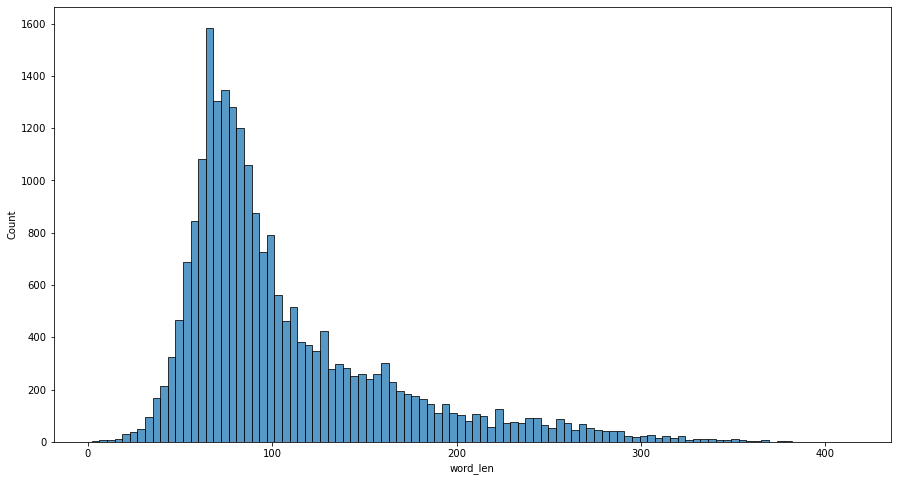

In [11]:
# visualizing count of the news data by number of words
plt.figure(figsize=(15,8))
sns.histplot(data=data,x='word_len')

# Proceedure 2- Input data preprocessing,label data encoding & Train/Test split.

In [12]:
# for the text data processing,we would the "Tokenizer" module from keras & to pad the tokenised data we would use the
# "pad_sequence" module also from keras..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In order to pad the tokenised data,the "pad_sequence" function would need a maxlen value to standardise the length of all the  tokenised data. The plan is to use the mean value of all the word lengths as the "maxlen" value..

In [13]:
# getting length of each text in the data
lx = []
for v in range(0,len(data)):
    lx.append(len(data.iloc[v][0]))

In [14]:
from functools import reduce

In [15]:
# summing all the text lengths & divided the result by the number of text values in the dataset to get the mean.
def round_off(acc, item):
    return acc + item
pad_val = reduce(round_off, lx, 0)
pad_val = round(pad_val/len(lx))
pad_val

106

In [16]:
# creating a function to tag the target sentiments with numeric values.
def tag(x):
    if x == 'positive':
        x = 1
    if x == 'negative':
        x = 2
    if x == 'neutral':
        x = 0
    return x

In [17]:
X = data['text'].values
y = data['sentiment'].apply(tag)

In [18]:
# because we're doing categorical classification we would have to do one-hot encoding with the target values
y = pd.get_dummies(y)

In [19]:
# tokenising & padding the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X,maxlen=pad_val)

In [20]:
# doing train/test split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Proceedure 3- Building,training & evaluating the LSTM model

In [ ]:
# The model we would be using is the "Sequential" model from keras,the model will be built with the "Embedding" layer for 
# vectorising the tokenised data,2 "LSTM" layers as the main operational layers for the model & a "Dense" layer to flatten the
# "LSTM" output & make the final prediction. We also add a "SpatialDropout1D" layer under the "Embedding" layer to prevent
# overfitting,by randomly switching off random units in 1-dimension during every iteration.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# creating an "EarlyStopping" instance to manage callbacks when overfitting is noticed in the model
earlystop = EarlyStopping(patience=2)

In [22]:
# building the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=100,input_length=pad_val))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(100,dropout=0.6,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(100,dropout=0.4,recurrent_dropout=0.5))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer="adam",loss="categorical_crossentropy")

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 106, 100)          2512100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 106, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 106, 100)          80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 2,673,203
Trainable params: 2,673,203
Non-trainable params: 0
______________________________________________

In [23]:
# model training & validation
model.fit(X_train,y_train,epochs=15,batch_size=128,validation_data=(X_test,y_test),callbacks=earlystop)

Epoch 1/15
125/125 [==============================] - 229s 2s/step - loss: 1.0438 - val_loss: 0.9302
Epoch 2/15
125/125 [==============================] - 265s 2s/step - loss: 0.9047 - val_loss: 0.8112
Epoch 3/15
125/125 [==============================] - 286s 2s/step - loss: 0.7802 - val_loss: 0.7175
Epoch 4/15
125/125 [==============================] - 271s 2s/step - loss: 0.6873 - val_loss: 0.6497
Epoch 5/15
125/125 [==============================] - 268s 2s/step - loss: 0.6205 - val_loss: 0.6325
Epoch 6/15
125/125 [==============================] - 269s 2s/step - loss: 0.5705 - val_loss: 0.6069
Epoch 7/15
125/125 [==============================] - 271s 2s/step - loss: 0.5135 - val_loss: 0.5935
Epoch 8/15
125/125 [==============================] - 279s 2s/step - loss: 0.4649 - val_loss: 0.6264
Epoch 9/15
125/125 [==============================] - 287s 2s/step - loss: 0.4241 - val_loss: 0.6050


<AxesSubplot:>

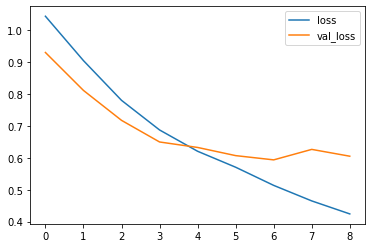

In [24]:
# visualising the loss validation
loss = pd.DataFrame(model.history.history)
loss.plot()

In [25]:
import numpy as np

In [26]:
# testing the model
pred =  np.round(model.predict(X_test)).astype(int)
pred

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [27]:
from sklearn.metrics import classification_report,confusion_matrix, explained_variance_score

In [76]:
# model evaluation
print(classification_report(y_test,pred,zero_division=1))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78      2974
           1       0.75      0.82      0.78      2380
           2       0.72      0.64      0.68      1468

   micro avg       0.78      0.74      0.76      6822
   macro avg       0.77      0.73      0.75      6822
weighted avg       0.79      0.74      0.76      6822
 samples avg       0.80      0.74      0.74      6822



# Proceedure 4- Deploying the model to check it's performanance on unfamiliar data.

In [35]:
# importing the new data
data2 = pd.read_csv('lstm_sub.csv')
data2.reset_index(inplace=True)
data2 = data2.drop(['Unnamed: 0','index'],axis=1)
data2 = data2.dropna()
data2.head()

,text
0,"['KennyDegu', 'little', 'volume', '10T', 'youd..."
1,"['ESF', 'achieved', 'Target', '2780', 'closing..."
2,"['RT', 'KimbleCharting', 'SilverGold', 'indica..."
3,"['Issaquahfunds', 'Hedged', 'MSFT', 'position'..."
4,"['RT', 'zipillinois', '3', 'Surprisingly', 'Co..."


In [36]:
# tokenising & padding the new data with the template of the data used to train the model
X_dep = tokenizer.texts_to_sequences(data2['text'])
X_dep = pad_sequences(X_dep,maxlen=pad_val)

In [45]:
# prediction the target values for the new data
dep_pre = np.round(model.predict(X_dep)).astype(int)
dep_pre

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [53]:
# creating a function to rewrite the target values from one-hot vectors to real numbers
def evaluate(x):
    lst = []
    for v in x:
        try: # from analysis it seems the model didn't make preidctions for some set of values in data,so we accomodate for 
            # such situation.
            v = list(v)
            lst.append(v.index(1))
        except ValueError:
            lst.append('no pred')
    return lst

In [55]:
dep_pre = evaluate(dep_pre)
dep_pre

In [61]:
dep_pre = pd.Series(dep_pre)

In [66]:
# checking the percentage of each predicted class in the new data
print(f'The model predicted {round((dep_pre.value_counts()[1]/len(data2))*100)}% positive values in the dataset')
print(f'The model predicted {round((dep_pre.value_counts()[2]/len(data2))*100)}% negative values in the dataset')
print(f'The model predicted {round((dep_pre.value_counts()[0]/len(data2))*100)}% neutral values in the dataset')
print(f'The model made {round((dep_pre.value_counts()["no pred"]/len(data2))*100)}% no predictions in the dataset')

The model predicted 44% positive values in the dataset
The model predicted 18% negative values in the dataset
The model predicted 27% neutral values in the dataset
The model made 12% no predictions in the dataset


# Project Summary
The aim of the project was to deploy an LSTM deep learning model to perform Sentiment analysis on financial news text data.